# Libraries

In [1]:
!pip install sdv==1.3.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from Data_Augmentation.vpower_src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [3]:
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.lite import SingleTablePreset
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import CopulaGANSynthesizer
from sdv.sequential import PARSynthesizer

In [4]:
torch.cuda.is_available()

True

# Data pre-processing

Données:
- data_all : ensemble de **tous les vols**, toutes les données, tous les features, ...
- data_flight1  : toutes les données/dfeatures uniquement du **vol 1**
- data_flight1_features : données du **vol 1** et limitation des features utilisés

- real_data : données de **training** de **tous les vols**
- real_data_flight1 : données de **training** du **vol 1**
- real_data_flight1_shorted : données de **training** du **vol 1**, réduites (supp: Power_smoothed < 300)

Caractéristiques: tous les vols/vol unique; tous les features/features limités; données filtrées ou non
-> Travailler avec les données de training uniquement ("real_data_***")


In [5]:
data_dir_s =  "../../Data/synthetic_data"
data_dir_r =  "../../Data/split_quad"
data_dir_da = "../../Data/augmented_data"
data_tag="RD"

In [6]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
#for partition in ["train", "dev_in", "dev_out"]:
#    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="index")
#    data_all[partition+"_s"] = df
for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["test"]=data_all["test_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["test"] = pd.concat([data_all["test_r"], data_all["test_s"]])
    

data_flight1 = {}
data_flight1["train"] = data_all["train"].loc[data_all["train"]["flight"] == 1]
data_flight1["test"] = data_all["test"].loc[data_all["test"]["flight"] == 1]
data_flight1["train"]


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
112,2019-04-07 10:13:00,1,0.00,1.4,37.0,24.178350,0.389637,-79.782396,40.458047,270.407091,...,-0.000479,0.033248,-0.114812,-9.824341,4,0,25,R5,9.420778,9.420778
113,2019-04-07 10:13:00,1,0.21,1.4,36.0,23.517269,6.154673,-79.782396,40.458047,270.432353,...,0.011397,0.042173,-0.108319,-9.837841,4,0,25,R5,144.741104,144.741104
114,2019-04-07 10:13:00,1,0.31,1.4,42.0,24.109488,1.025779,-79.782396,40.458047,270.433609,...,0.017794,0.005411,-0.188141,-9.812851,4,0,25,R5,24.731003,24.731003
115,2019-04-07 10:13:00,1,0.50,1.4,42.0,24.189619,0.278312,-79.782396,40.458047,270.459037,...,-0.005043,0.034055,-0.114786,-9.808225,4,0,25,R5,6.732263,6.732263
116,2019-04-07 10:13:00,1,0.61,1.3,41.0,24.192123,0.389637,-79.782396,40.458047,270.460150,...,-0.012929,0.008335,-0.094107,-9.812603,4,0,25,R5,9.426145,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2019-04-07 10:13:00,1,169.10,1.7,92.0,22.500603,5.033473,-79.782354,40.458037,268.150388,...,0.022862,0.264301,0.581728,-9.760308,4,0,25,R5,113.256177,113.256177
1240,2019-04-07 10:13:00,1,169.20,1.7,90.0,22.493092,5.089135,-79.782354,40.458037,268.170896,...,-0.011390,0.207800,0.540354,-9.742634,4,0,25,R5,114.470383,114.470383
1241,2019-04-07 10:13:00,1,169.30,1.7,92.0,22.498098,5.025521,-79.782354,40.458037,268.153808,...,-0.000938,0.246509,0.592650,-9.784649,4,0,25,R5,113.064672,113.064672


In [7]:
input_features = [
    #time_start,
    "flight",
    "time",
    "wind_speed",
    "wind_angle",
    #battery_voltage,
    #battery_current,
    #position_x,
    #position_y,
    "position_z",
    "orientation_x",
    "orientation_y",
    "orientation_z",
    "orientation_w",
    "velocity_x",
    "velocity_y",
    "velocity_z",
    "angular_x",
    "angular_y",
    "angular_z",
    "linear_acceleration_x",
    "linear_acceleration_y",
    "linear_acceleration_z",
    #speed,
    #payload,
    #altitude,
    #route,
    #power,
    "power_smoothed"
]


In [8]:
data_flight1_features = {}
data_flight1_features["train"] = pd.DataFrame(data_flight1["train"][input_features])
data_flight1_features["test"] = pd.DataFrame(data_flight1["test"][input_features])

In [9]:
real_data = data_all["train"]
print("Real_Data Length: ", len(real_data))

real_data_flight1 = data_flight1["train"]
print("Real_Data_flight1 Length: ", len(real_data_flight1))

Real_Data Length:  139006
Real_Data_flight1 Length:  815


In [10]:
# Delete values of Power_Smoothed < 300 (according to the graph obtained with all the data flight values)

real_data_flight1_shorted = real_data_flight1[real_data_flight1['power_smoothed'] > 300]

# Synthesizers - Sequential Data

In [11]:
#real_data.astype({'flight':'id'})
#print(real_data.dtypes)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)
#print(metadata)
metadata.update_column(column_name='flight', sdtype='id')
metadata.set_sequence_key(column_name='flight')
print('Auto detected data:\n')
metadata

Auto detected data:



{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time_start": {
            "sdtype": "categorical"
        },
        "flight": {
            "sdtype": "id"
        },
        "time": {
            "sdtype": "numerical"
        },
        "wind_speed": {
            "sdtype": "numerical"
        },
        "wind_angle": {
            "sdtype": "numerical"
        },
        "battery_voltage": {
            "sdtype": "numerical"
        },
        "battery_current": {
            "sdtype": "numerical"
        },
        "position_x": {
            "sdtype": "numerical"
        },
        "position_y": {
            "sdtype": "numerical"
        },
        "position_z": {
            "sdtype": "numerical"
        },
        "orientation_x": {
            "sdtype": "numerical"
        },
        "orientation_y": {
            "sdtype": "numerical"
        },
        "orientation_z": {
            "sdtype": "numerical"
        },
        "orientation_w": {
     

In [12]:
# A: GaussianCopulaSynthesizer

# Step 1.A: Create the synthesizer
synthesizer_PAR = PARSynthesizer(metadata, verbose=True, cuda=True)

In [14]:
# Step 2.A: Train the synthesizer
#synthesizer_PAR.fit(real_data)
#synthesizer_PAR.save(filepath='../Models/my_PARSynthesizer.pkl')
synthesizer_PAR = PARSynthesizer.load(filepath='../Models/my_PARSynthesizer.pkl')

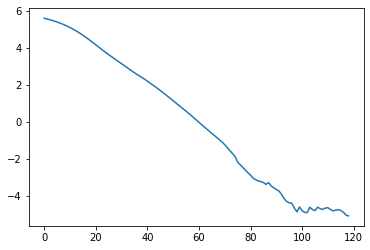

In [15]:
# Loss for all (almost, missing few first ones) the epoch
lossPAR = [5.61367654800415, 5.57807731628418, 5.5401411056518555, 5.499541282653809, 5.455877780914307, 5.408817291259766, 5.358036994934082, 5.303194522857666, 5.244025707244873, 5.180243015289307, 5.111593723297119, 5.038076400756836, 4.959540843963623, 
 4.875914573669434, 4.787439346313477, 4.694278717041016, 4.59680700302124, 4.495439052581787, 4.390927791595459, 4.284075736999512, 4.175786018371582, 4.06706428527832, 3.95858097076416, 3.8513269424438477, 3.7461907863616943, 3.6435627937316895, 
 3.54341459274292, 3.44521164894104, 3.3478329181671143, 3.250467300415039, 3.1527416706085205, 3.0542538166046143, 2.9547629356384277, 2.8550217151641846, 2.757145404815674, 2.66286301612854, 2.5725693702697754, 2.485039472579956, 2.397214651107788, 
 2.3059558868408203, 2.2099387645721436, 2.1104626655578613, 2.009934902191162, 1.9098334312438965, 1.8094923496246338, 1.7062788009643555, 1.5981183052062988, 1.4859620332717896, 1.3724807500839233, 1.2606391906738281, 1.1493929624557495, 1.0363414287567139, 
 0.921712338924408, 0.8087166547775269, 0.6968011856079102, 0.5822632312774658, 0.4650786817073822, 0.3456471860408783, 0.22543329000473022, 0.10476095229387283, -0.01988951489329338, -0.1414669305086136, -0.2630211412906647, -0.3841879963874817, -0.5021893382072449, 
 -0.6218210458755493, -0.736971914768219, -0.8485569357872009, -0.9730013608932495, -1.0954195261001587, -1.2305676937103271, -1.3912659883499146, -1.5530575513839722, -1.7059344053268433, -1.8727335929870605, -2.17323899269104, -2.314803123474121, -2.4610373973846436,
 -2.6088318824768066, -2.750373363494873, -2.8781769275665283, -3.0444061756134033, -3.1290388107299805, -3.1976776123046875, -3.2284131050109863, -3.279860734939575, -3.3828530311584473, -3.2849223613739014, -3.4638984203338623, -3.565347671508789, -3.6632699966430664, 
 -3.734891414642334, -3.9145758152008057, -4.14608097076416, -4.304861545562744, -4.3807454109191895, -4.397669792175293, -4.668130874633789, -4.865088939666748, -4.602038860321045, -4.804028511047363, -4.9009575843811035, -4.902499198913574, -4.615546703338623, 
 -4.746067047119141, -4.804479122161865, -4.616731643676758, -4.693030834197998, -4.736988067626953, -4.664133071899414, -4.643364906311035, -4.740890026092529, -4.8141865730285645, -4.775677680969238, -4.747072696685791, -4.79392671585083, -4.888744831085205, -5.041872501373291, -5.088444709777832]
plt.plot(lossPAR)
plt.show()

In [16]:
# Step 3.A: Generate synthetic data
synthetic_data_PAR = synthesizer_PAR.sample(num_sequences=10)
print(len(synthetic_data_PAR))


  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:942: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|██████████| 10/10 [03:20<00:00, 20.03s/it]

5492


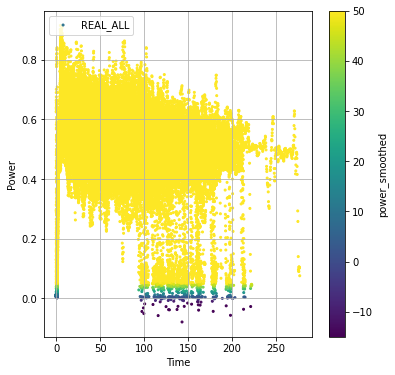

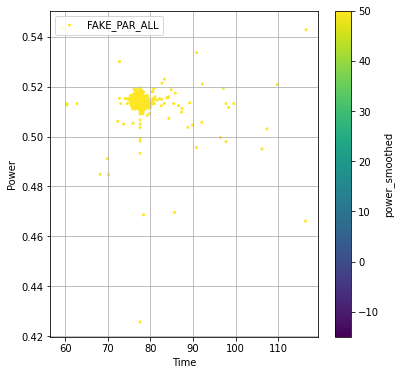

In [17]:
############################################################ Real Data
feature_under_study = "power_smoothed"

plt.figure(figsize=(6, 6))
plt.scatter(real_data["time"], real_data['power_smoothed'] / 1e3,
            c=real_data[feature_under_study],
            s=4, label="REAL_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

############################################################ Gaussian
plt.figure(figsize=(6, 6))
plt.scatter(synthetic_data_PAR["time"],synthetic_data_PAR['power_smoothed'] / 1e3,
            c=synthetic_data_PAR[feature_under_study],
            s=4, label="FAKE_PAR_ALL")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("Power")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()
